In [ ]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [1]:
%autosave 0
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import torch

Autosave disabled


# Linear Regression

In linear regression we have a 
- continuous one-dimensional target $y$ 
- continuous D-dimensional input $x$ 

related by a linear mapping

$$
b + \sum_{d=1}^D w_d x_d = f_\theta(x)  \rightarrow y
$$

> The model is specified by $\theta=(b, w_1, w_2, \ldots, w_D)$

Typically, we fit this model by 
$$
\min_\theta\sum_n \left(y_n - f_\theta(x_n) \right)^2 = (Y - \Phi \theta)^T (Y - \Phi \theta)
$$

whose solution is

$$
\theta = (\Phi^T \Phi)^{-1} \Phi^T Y,
$$

where $\Phi  = \begin{pmatrix} 1 & x_{11} & x_{12} & \ldots & x_{1D} \\ 
1 & x_{21} & x_{22} & \ldots & x_{2D} \\
1 & \vdots & \vdots & \ddots & \vdots \\
1 & x_{N1} & x_{N2} & \ldots & x_{ND} \end{pmatrix}$,  $Y = \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_N \end{pmatrix}$ and  $\theta =  \begin{pmatrix} b \\ w_1 \\ \vdots \\ w_D \end{pmatrix}$

> This is known as the ordinary least squares (OLS) solution

#### Note: Linear regression is *linear on the parameters*

If we apply transformations we obtain the same solution. The only difference is in $\Phi$

For example
- Polynomial basis regression $f_\theta(x) = \sum_d w_d x^d + b$ 
- Sine-wave basis regression $f_\theta(x) = \sum_d \alpha_d \cos(2\pi d f_0 x)  + \sum_d \beta_d \sin(2\pi d f_0 x) + c$ 

### Probabilistic linear regression

We can assume that observations are noisy and write

$$
\begin{align}
y &= f_\theta(x) + \epsilon \nonumber \\
&= b + \sum_{d=1}^D w_d x_d   + \epsilon, \nonumber
\end{align}
$$

If the noise is independent and Gaussian distributed (iid) with variance $\sigma_\epsilon^2$ then

$$
p(y|x, \theta) = \mathcal{N}\left(y| f_\theta(x) , \sigma_\epsilon^2 \right)
$$

Additionally, we may want to discourage large values of $\theta~$ by placing a prior

$$
p(\theta) = \mathcal{N}(0, \Sigma_\theta)
$$

The prior on the parameters gives us the space of possible models (before presenting data)

<IPython.core.display.Javascript object>


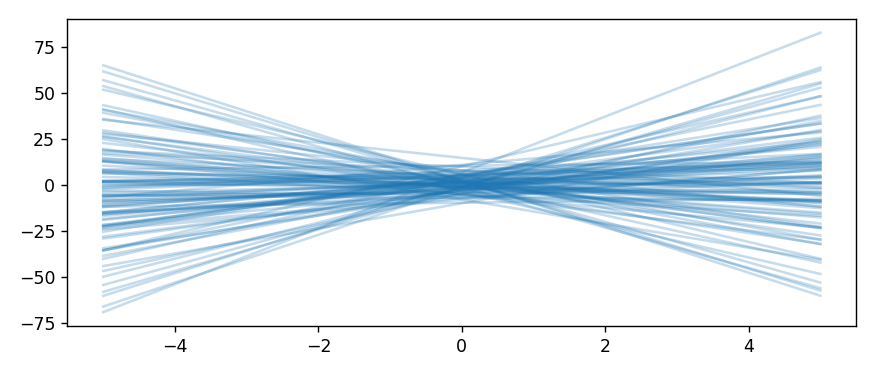

In [2]:
line_x = np.linspace(-5, 5, num=100)[:, None].astype('float32') #100x1

sw, sb = 5., 5.
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
for i in range(100):
    linear_layer = torch.nn.Linear(1, 1)
    torch.nn.init.normal_(linear_layer.weight, 0.0, sw)
    torch.nn.init.normal_(linear_layer.bias, 0.0, sb)
    #y = W*x + b
    line_y = linear_layer(torch.from_numpy(line_x)).detach().numpy()
    ax.plot(line_x, line_y, c='tab:blue', alpha=0.25)

We constraint the space of solutions by presenting data

### Point-estimate solution (MAP)

For a dataset $\mathcal{D} = \{ (x_1, y_1), (x_2, y_2), \ldots, (x_N, y_N) \}$

The Maximum a posteriori estimator of $\theta~$ is given by
$$
\begin{align}
\hat \theta &= \text{arg}\max_\theta \log p(\mathcal{D}| \theta, \sigma_\epsilon^2) ~ \mathcal{N} (\theta|0, \Sigma_\theta) \nonumber  \\
&= \text{arg}\min_\theta  \frac{1}{2\sigma_\epsilon^2} (Y-\Phi\theta)^T (Y - \Phi\theta) + \frac{1}{2} \theta^T \Sigma_\theta^{-1} \theta  \nonumber
\end{align}
$$
where the log likelihood is
$$
\log p(\mathcal{D}| \theta, \sigma_\epsilon^2) = \sum_{n=1}^N \log \mathcal{N}(y_n|f_\theta(x_n),\sigma_\epsilon^2)
$$
and the result is
$$
\hat \theta = (\Phi^T \Phi + \lambda )^{-1} \Phi^T Y
$$
where $\lambda = \sigma_\epsilon^2 \Sigma_\theta^{-1}$

> This is the ridge regression or **regularized least squares** solution

What happens if the variance of the prior tends to infinite (uninformative prior)?


### Bayesian solution for the parameters

In this case we want the posterior of $\theta~$ given the dataset

Assuming that we know $\sigma_\epsilon$

$$
p(\theta|\mathcal{D}, \sigma_\epsilon^2) \propto  \mathcal{N}(Y| \Phi \theta, I\sigma_\epsilon^2) \mathcal{N}(\theta| \theta_0, \Sigma_{\theta_0})
$$

The likelihood is normal and the prior is normal, so
$$
p(\theta|\mathcal{D}, \sigma_\epsilon^2) \propto \frac{1}{Z} \exp \left ( -\frac{1}{2\sigma_\epsilon^2} (Y-\Phi\theta)^T (Y - \Phi\theta)  - \frac{1}{2} (\theta - \theta_{0})^{T} \Sigma_{\theta_0}^{-1} (\theta - \theta_0)\right)
$$

and (with a bit of algebra) it can be shown that this corresponds to a normal distribution 

$$
p(\theta|\mathcal{D}, \sigma_\epsilon^2) = \mathcal{N}(\theta|\theta_1, \Sigma_{\theta_1} )
$$

with parameters 
$$
\Sigma_{\theta_1} = \sigma_\epsilon^2 (\Phi^T \Phi + \sigma_\epsilon^2  \Sigma_{\theta_0}^{-1})^{-1}
$$
$$
\theta_1 = \Sigma_{\theta_1} \Sigma_{\theta_0}^{-1} \theta_{0} + \frac{1}{\sigma_\epsilon^2} \Sigma_{\theta_1} \Phi^T y
$$

> **Iterative framework:** We can present data and update the distribution of $\theta~$

#### Fitting a line

We assume a zero-mean and diagonal covariance normal prior

In [3]:
# Initialization
mw, mb = 0., 0.
sw, sb = 5., 5.
So = np.diag(np.array([sb, sw])**2)
mo = np.array([mb, mw])
seps = 1. # What happens if this is larger/smaller?

The empirical distribution of $\theta$

<IPython.core.display.Javascript object>


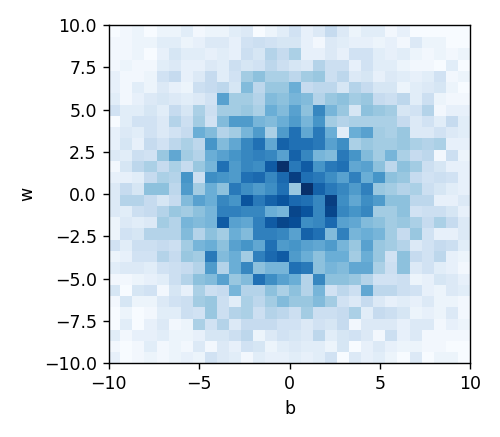

In [4]:
fig, ax = plt.subplots(figsize=(4, 3.5), tight_layout=True)
theta_plot = np.random.multivariate_normal(mo, So, size=10000)
ax.hist2d(theta_plot[:, 0], theta_plot[:, 1], bins=30, 
          range=((-10, 10), (-10, 10)), cmap=plt.cm.Blues)
ax.set_xlabel('b'); ax.set_ylabel('w');

We observe data at $x=2$, $y=0$ and we update the parameters

In [5]:
#Update
Phi = np.array([[1.0, 2.0]])
y = np.array([0.0])
Sn = seps**2*np.linalg.inv(np.dot(Phi.T, Phi) +  seps**2*np.linalg.inv(So))
mn = np.dot(Sn, np.linalg.solve(So, mo)) + np.dot(Sn, np.dot(Phi.T, y))/seps**2
display(Sn, mn)

array([[20.03968254, -9.92063492],
       [-9.92063492,  5.15873016]])

array([0., 0.])

The updated empirical distribution is 

<IPython.core.display.Javascript object>


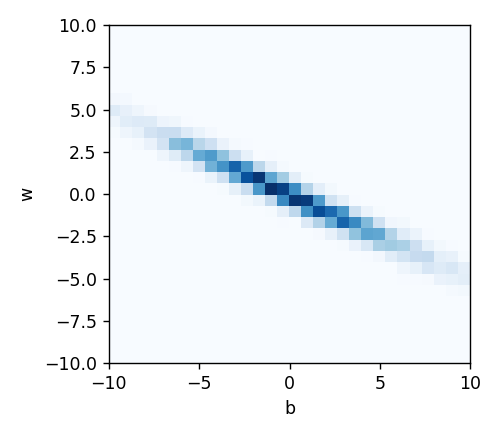

In [6]:
fig, ax = plt.subplots(figsize=(4, 3.5), tight_layout=True)
theta_plot = np.random.multivariate_normal(mn, Sn, size=10000)
ax.hist2d(theta_plot[:, 0], theta_plot[:, 1], bins=30, 
          range=((-10, 10), (-10, 10)), cmap=plt.cm.Blues)
ax.set_xlabel('b'); ax.set_ylabel('w');

and the space of possible models is constrained

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)

for i in range(100):
    linear_layer = torch.nn.Linear(1, 1)
    rparam = torch.from_numpy(np.random.multivariate_normal(mn, Sn).astype('float32'))
    linear_layer.weight.data = rparam[1].reshape(-1, 1)
    linear_layer.bias.data = rparam[0].reshape(-1, 1)
    line_y = linear_layer(torch.from_numpy(line_x)).detach().numpy()
    ax.plot(line_x, line_y, c='tab:blue', alpha=0.25)

ax.errorbar(2, 0, xerr=0, yerr=2*seps, fmt='none', c='k', zorder=100);

Let's assume that we observe a additional data point at $x=-2$, $y=-2$

In [7]:
# Initialization
So = Sn
mo = mn
#Update
Phi = np.array([[1.0, -2.0]])
y = np.array([-2.0])
Sn = seps**2*np.linalg.inv(np.dot(Phi.T, Phi) +  seps**2*np.linalg.inv(So))
mn = np.dot(Sn, np.linalg.solve(So, mo)) + np.dot(Sn, np.dot(Phi.T, y))/seps**2
display(Sn, mn)

array([[4.90196078e-01, 1.08303875e-16],
       [1.08303875e-16, 1.24378109e-01]])

array([-0.98039216,  0.49751244])

Empirical distribution:

<IPython.core.display.Javascript object>


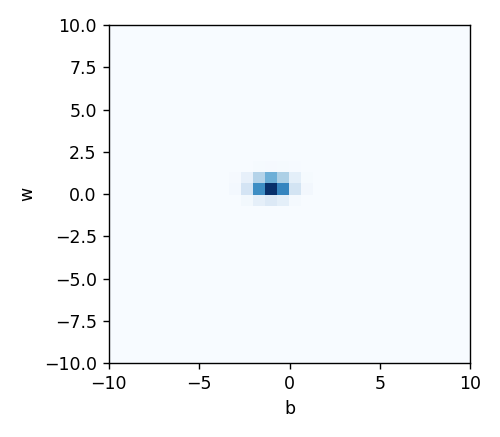

In [8]:
fig, ax = plt.subplots(figsize=(4, 3.5), tight_layout=True)
theta_plot = np.random.multivariate_normal(mn, Sn, size=10000)
ax.hist2d(theta_plot[:, 0], theta_plot[:, 1], bins=30, 
          range=((-10, 10), (-10, 10)), cmap=plt.cm.Blues)
ax.set_xlabel('b'); ax.set_ylabel('w');

And the lines are constrained even more

<IPython.core.display.Javascript object>


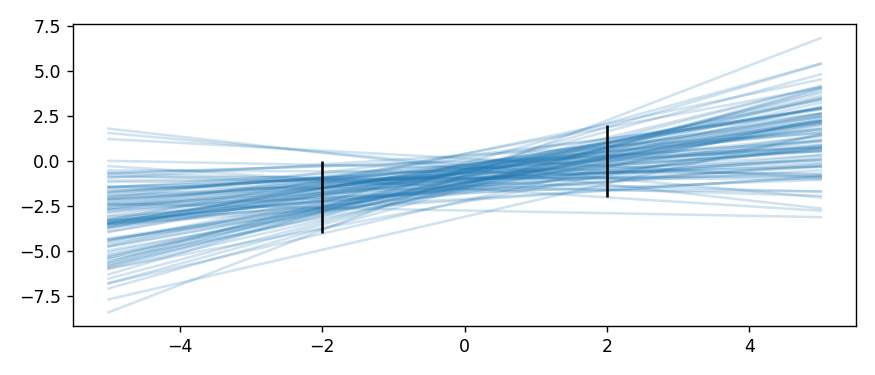

In [9]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)

for i in range(100):
    linear_layer = torch.nn.Linear(1, 1)
    rparam = torch.from_numpy(np.random.multivariate_normal(mn, Sn).astype('float32'))
    linear_layer.weight.data = rparam[1].reshape(-1, 1)
    linear_layer.bias.data = rparam[0].reshape(-1, 1)
    line_y = linear_layer(torch.from_numpy(line_x)).detach().numpy()
    ax.plot(line_x, line_y, c='tab:blue', alpha=0.2)

ax.errorbar(2, 0, xerr=0, yerr=2*seps, fmt='none', c='k', zorder=100);
ax.errorbar(-2, -2., xerr=0, yerr=2*seps, fmt='none', c='k', zorder=100);

### Bayesian solution for the predictions

Don't forget our goal

> We train the model to predict $y$ for new values of $x$

In the Bayesian setting we are interested in the **posterior predictive distribution**

This is obtained by marginalizing $\theta$

$$
\begin{align}
p(y | x, \mathcal{D}) &= \int p(y, \theta | x, \mathcal{D}) d\theta \nonumber \\
&= \int p(y| \theta, x, \mathcal{D}) p(\theta| \mathcal{D}) d\theta \nonumber \\
&= \int p(y| \theta, x) p(\theta| \mathcal{D}) d\theta, \nonumber 
\end{align}
$$
note that $y$ is conditionally independant on $\mathcal{D}$ given $\theta$

For our linear regression
$$
\begin{align}
p(y|x, \mathcal{D}, \sigma_\epsilon^2) &= \int p(y|f_\theta(x), \sigma_\epsilon^2) p(\theta| \theta_{N}, \Sigma_{\theta_N}) d\theta \nonumber \\
&= \mathcal{N}\left(y|f_{\theta_N} (x), \sigma_\epsilon^2 + x^T \Sigma_{\theta_N} x\right)
\end{align}
$$

**The posterior predictive is Gaussian** (convolution of gaussians is gaussian)

If we consider that $N$ samples were presented and that $\mu_0=0$ then 

$$
\theta_{N} =  (\Phi^T \Phi + \sigma_\epsilon^2 \Sigma_{\theta_0}^{-1})^{-1} \Phi^T y
$$

which is the MAP estimator, and

$$
\Sigma_{\theta_N} = \sigma_\epsilon^2 (\Phi^T \Phi + \sigma_\epsilon^2 \Sigma_{\theta_0}^{-1})^{-1}
$$


Finally, the variance (uncertainty) for the new $x$ is 
$$
\sigma^2(x) = \sigma_\epsilon^2 + x^T \Sigma_{\theta_N} x
$$

> The variance of the prediction has contribution from the noise (irreducible) and the model 

Uncertainty grows when we depart from the observed data points

<IPython.core.display.Javascript object>


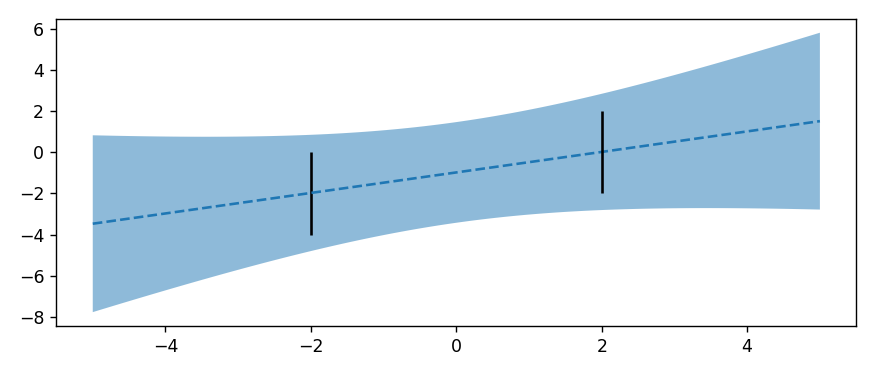

In [10]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)

Phi_x = np.vstack(([1]*100, line_x[:, 0])).T
sx = np.sqrt(np.diag(seps**2 + np.dot(np.dot(Phi_x, Sn), Phi_x.T)))
ax.plot(line_x, np.dot(Phi_x, mn), '--')
ax.fill_between(line_x[:, 0], np.dot(Phi_x, mn)-2*sx, np.dot(Phi_x, mn)+2*sx, alpha=0.5)
ax.errorbar(2, 0, xerr=0, yerr=2*seps, fmt='none', c='k', zorder=100);
ax.errorbar(-2, -2., xerr=0, yerr=2*seps, fmt='none', c='k');

**Activity:**

See how the posterior predictive distribution changes with increasing/decreasing $\sigma_\epsilon$ and $\Sigma_{\theta_0}$

# Self-study

- [Chapter 18 of D. Barber's book](http://web4.cs.ucl.ac.uk/staff/D.Barber/pmwiki/pmwiki.php?n=Brml.Online)
- In all this we assumed $\sigma_\epsilon$ known. For a bayesian treatment with unknown noise variance we would use a normal gamma prior

## Model Evidence for Bayesian Linear Regression

Next iteration

# PyTorch tutorial

- https://github.com/magister-informatica-uach/INFO267/blob/master/unidad1/3_redes_neuronales.ipynb
- https://github.com/magister-informatica-uach/INFO267/blob/master/unidad1/4_red_convolucional.ipynb


# Polynomial (linear) regression with Pytorch

Let's create synthetic data

We will fit this with a polynomial model

<IPython.core.display.Javascript object>


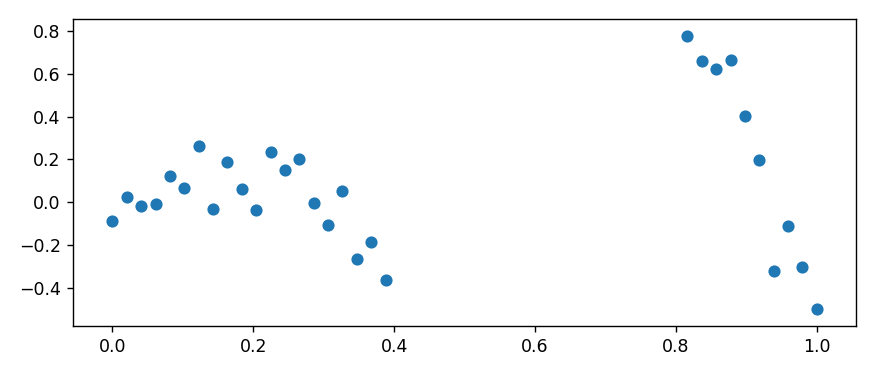

In [11]:
# Synthetic data
se = 0.1
x_plot = np.linspace(0, 1, num=50).astype('float32') #100x1
y_clean = x_plot*np.sin(10*x_plot)
x = np.delete(x_plot, slice(20, 40))
y_clean = np.delete(y_clean, slice(20, 40))
y = y_clean + se*np.random.randn(len(x))
#y = (y - np.mean(y))/np.std(y)
y = y.astype('float32')
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.scatter(x, y);

x_torch = torch.from_numpy(x[:, None])
x_test = torch.from_numpy(x_plot[:, None])
y_torch = torch.from_numpy(y).unsqueeze(1)

The linear regressor model in PyTorch has one layer and no activation

We keep the degree of the pynomial as a free parameter

In [12]:
class LinearRegressor(torch.nn.Module):
    def __init__(self, degree=10):
        super(LinearRegressor, self).__init__()
        assert degree>0, "Degree has to be greater than zero"
        assert type(degree)==int, "Degree has to be an integer"
        self.degree = degree
        self.linear = torch.nn.Linear(degree, 1, bias=True)

    def forward(self, x):
        # polynomial expansion
        phi = torch.stack([x[:, 0]**(k+1) for k in range(self.degree)], dim=1)
        # linear layer
        return self.linear(phi)

We train this model using the Mean Square Error loss, i.e.

> We assumme a Gaussian likelihood

and batch GD with adaptive learning rate and momentum (Adam)

With the `weight_decay` parameters of Adam we can add L2 regularization easily

> If we add L2 then we are obtaining MAP estimates with Gaussian likelihood and a Gaussian prior 

**Activity:**

1. Change the number of basis and describe the results
1. Increase the noise and repeat the previous step
1. Modify the `weight_decay` parameter in Adam and repeat the previous steps 

Concepts: Complexity, generalization, overfitting, regularization

<IPython.core.display.Javascript object>


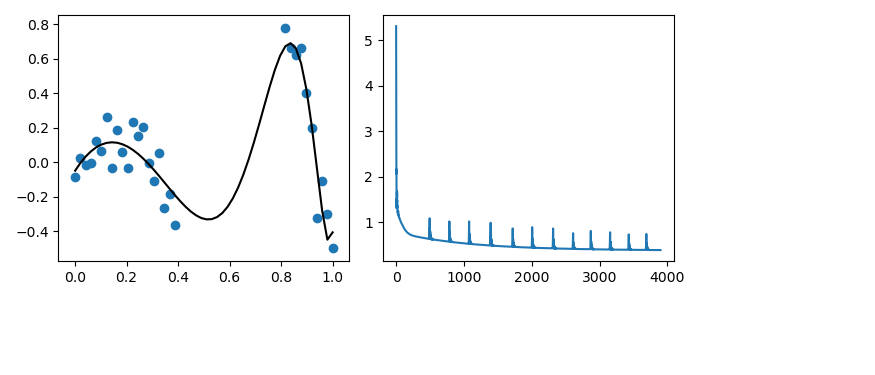

KeyboardInterrupt: 

In [13]:
model = LinearRegressor(degree=20) # Change the degree
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, 
                             amsgrad=False, weight_decay=0.0) # Change the weight decay

fig, ax = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True)
f = model.forward(x_test).detach().numpy()
line1 = ax[0].plot(x_test.detach().numpy(), f, 'k-')
line2 = ax[1].plot([], [])
ax[0].scatter(x, y)

epoch_loss = np.zeros(shape=(5000,))
for k in tqdm_notebook(range(len(epoch_loss))):
    optimizer.zero_grad()
    f = model.forward(x_torch)
    loss = criterion(y_torch, f)
    loss.backward()
    optimizer.step()
    epoch_loss[k] = loss.item()
    #break    
    if k % 100 == 0:
        f = model.forward(x_test).detach().numpy()
        line1[0].set_ydata(f)
        line2[0].set_xdata(range(k))
        line2[0].set_ydata(epoch_loss[:k])
        ax[1].relim()
        ax[1].autoscale_view()
        fig.canvas.draw()


# Artificial Neural networks

[Artificial neural networks](https://docs.google.com/presentation/d/1IJ2n8X4w8pvzNLmpJB-ms6-GDHWthfsJTFuyUqHfXg8/edit?usp=sharing) (ANN) are non-linear parametric function approximators built by connecting simple units

These units are simplified models of biological neurons: 

> Linear regressor followed by a non-linear activation function

Feed-forward ANN are organized in layers. Each layer has a certain amount of neurons (user-defined)

> **Multilayer perceptron (MLP) architecture:** Every unit is connected to all units of its previous and next layers

Different ways of connecting neurons yields different ANN architectures (convolutional, recurrent, etc)

Very deep neural network models are the current state of the art in pattern recognition problems 

> Subsequent layers form higher abstraction concepts

#### Why are deep models needed?

The MLP with one hidden layer (shallow network) is a universal approximator

> It theory one could obtain a shallow network that is as flexible as a deep network, but it may require an extremely large number of hidden-layer neurons (infinite)

In practice you need flexible but also compact models

#### MLP with Gaussian prior

The parameter vector $\theta$ includes the weights and biases of all the neurons

Let's consider a Gaussian prior for $\theta$ and study the space of possible models
- How does it compare to the linear regressor? 
- What happens when you add more neurons? 
- What happens if you remove the nonlinearity? 
- What happens if you change the nonlinearity?
- What happens when you add more layers?

<IPython.core.display.Javascript object>


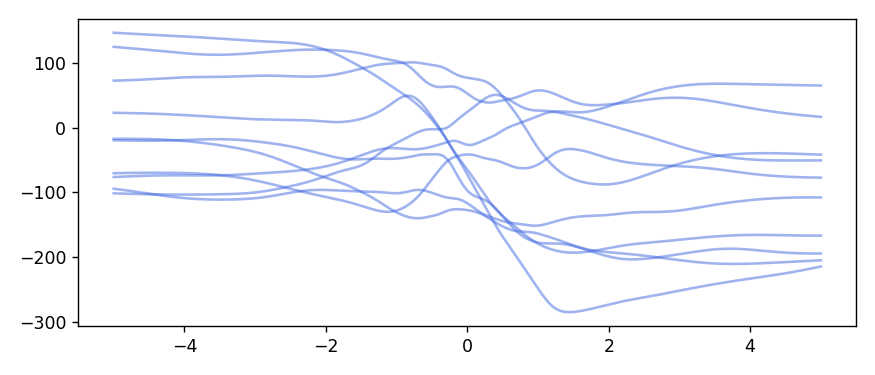

In [14]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
x_nn = np.linspace(-5, 5, num=1000)[:, None].astype('float32') #100x1

class MLP(torch.nn.Module):
    def __init__(self, Nh=10, sw=5, sb=5):
        super(MLP, self).__init__()
        self.hidden1 = torch.nn.Linear(1, Nh)
        #self.hidden2 = torch.nn.Linear(Nh, Nh)
        #self.hidden3 = torch.nn.Linear(Nh, Nh)

        self.output = torch.nn.Linear(Nh, 1)
        #for layer in [self.hidden1, self.hidden2, self.hidden3, self.output]:
        for layer in [self.hidden1, self.output]:
            torch.nn.init.normal_(layer.weight, 0.0, sw)
            torch.nn.init.normal_(layer.bias, 0.0, sb)
        self.activation = torch.nn.Sigmoid()

    def forward(self, x):
        z = self.activation(self.hidden1(x))
        #z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        return self.output(z)
    
for i in range(10):
    model = MLP(Nh=1000)
    y_nn = model.forward(torch.from_numpy(x_nn)).detach().numpy()
    ax.plot(x_nn, y_nn, c='royalblue', alpha=0.5)

## Probabilistic interpretation of ANN

Let's consider a simple MLP architecture for regression
- one hidden layer with $H$ neurons
- input dimensionality $D$ and output dimensionality $K$
- $g(\cdot)$ a nonlinear activation function (sigmoid, tanh, ReLU, etc)

The jth neuron in the hidden layer
$$
z_j =  g \left( b_j + \sum_{d=1}^D w_{jd} x_d  \right)
$$
The ith neuron in the output layer
$$
\begin{align}
f_i &=   b_i + \sum_{j=1}^H w_{ij} z_j  \nonumber \\
&=  b_i + \sum_{j=1}^H w_{ij} g \left( b_j + \sum_{d=1}^D w_{jd} x_d  \right) \nonumber
\end{align}
$$

The vector parameter $\vec \theta$ contains the weight and biases of both layers

We fit the parameters by minimizing the **Mean Square Error** cost function 

$$
\min_\theta \sum_n  \sum_i \left(y_{i}^{(n)} - f_i(x^{(n)}) \right)^2
$$

> This is equivalent to the **MLE solution with Gaussian likelihood** (known spherical covariance)

Typically an L2 regularizer is included to penalize complexity and improve generalization

$$
\min_\theta \sum_n  \sum_i  \left(y_{i}^{(n)} - f_i(x^{(n)}) \right)^2 + \lambda \sum_k \theta_k^2
$$

> This is equivalent to the **MAP solution with Gaussian likelihood and Gaussian prior** (zero-mean)

In both cases there is no closed-form solution and we optimize with iterative methods (gradient descent)


### In summary: Conventional neural network training obtains MLE/MAP point estimates

For classification we arrive to the same conclusion except that 
- sigmoid or softmax activation is used in the output layer
- cross-entropy cost function is used instead of MSE: **Bernoulli/Categorical likelihood**

## Non-linear regressor using MLP

Let's go back to the polynomial regression problem

<IPython.core.display.Javascript object>


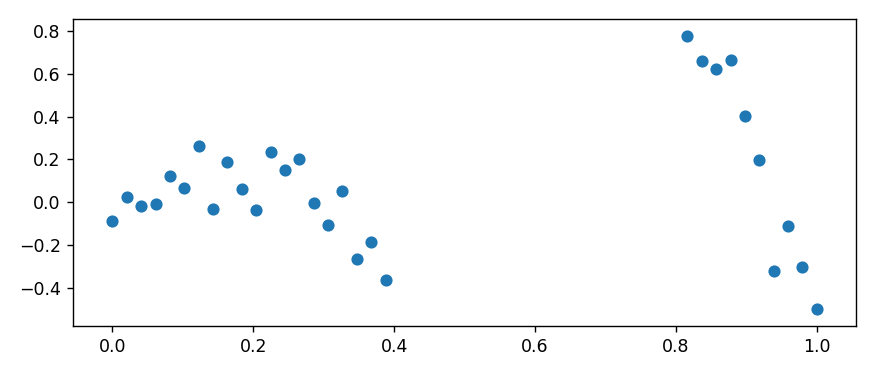

In [15]:
# Synthetic data
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.scatter(x, y);

This time we use a Multi-Layer Perceptron (MLP) neural network

We use a non-linear hyperbolic tangent activation function as hidden activation

In [16]:
class MLP(torch.nn.Module):
    def __init__(self, n_hidden=10):
        super(MLP, self).__init__()
        self.hidden1 = torch.nn.Linear(1, n_hidden, bias=True)
        #self.hidden2 = torch.nn.Linear(n_hidden, n_hidden, bias=True)
        self.output = torch.nn.Linear(n_hidden, 1, bias=True)
        self.activation = torch.nn.Tanh()
        
    def forward(self, x):
        z = self.activation(self.hidden1(x))
        #return self.output(self.activation(self.hidden2(z)))
        return self.output(z)

How many hyperbolic tangent basis do we need to fit this data?

<IPython.core.display.Javascript object>


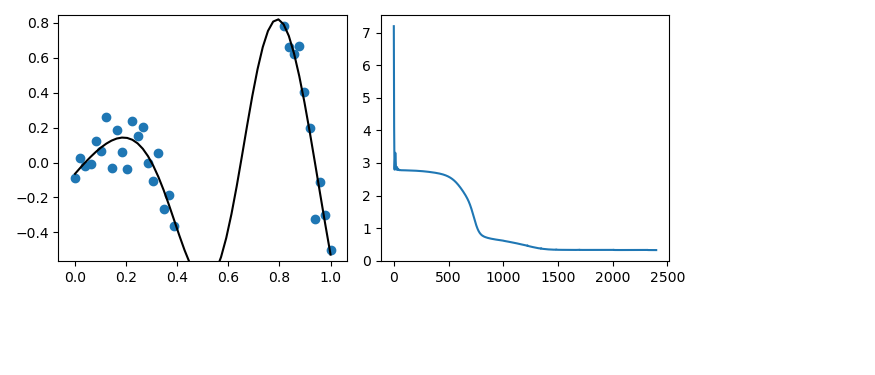

KeyboardInterrupt: 

In [17]:
model = MLP(n_hidden=10) # Change the degree

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, 
                             amsgrad=False, weight_decay=0.0) # Change the weight decay

x_torch = torch.from_numpy(x[:, None])
x_test = torch.from_numpy(x_plot[:, None])
y_torch = torch.from_numpy(y).unsqueeze(1)
fig, ax = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True)
f = model.forward(x_test).detach().numpy()
line1 = ax[0].plot(x_test.detach().numpy(), f, 'k-')
line2 = ax[1].plot([], [])
ax[0].scatter(x, y)

epoch_loss = np.zeros(shape=(10000,))
for k in tqdm_notebook(range(len(epoch_loss))):
    optimizer.zero_grad()
    f = model.forward(x_torch)
    loss = criterion(y_torch, f)
    loss.backward()
    optimizer.step()
    epoch_loss[k] = loss.item()
    #break    
    if k % 100 == 0:
        f = model.forward(x_test).detach().numpy()
        line1[0].set_ydata(f)
        line2[0].set_xdata(range(k))
        line2[0].set_ydata(epoch_loss[:k])
        ax[1].relim()
        ax[1].autoscale_view()
        fig.canvas.draw()

# Bayesian Neural Networks

In the bayesian setting we are interested in the posterior of the parameters and predictions

Assuming *iid* samples $\mathcal{D} =\{(x^{(1)}, y^{(1)}), \ldots \}$ we can write the posterior of $\theta$

$$
p(\theta | \mathcal{D}) = \frac{p(\mathcal{D}|\theta) p(\theta)}{p(\mathcal{D})} = \frac{1}{{p(\mathcal{D})}} \prod_n \mathcal{N}(y^{(n)} | f(x^{(n)}), \sigma^2) \mathcal{N}(\theta | 0, \Sigma_\theta)
$$

> Because of the nested nonlinearities this posterior is not Gaussian


> There is no easy way to get the normalizing constant (evidence) and hence the posterior

In this case we choose between MCMC and approximate inference: Laplace method, Variational Inference

# Pyro

Pyro can be used to perform MCMC and/or approximate inference for intractable posteriors

We can use Pyro to move from point estimates to posteriors in our **torch-based model**

In [18]:
import pyro

print(pyro.__version__)

pyro.set_rng_seed(101)

0.4.1


Let's start by creating a normal distributions

Distributions in Puro are picked from [`pyro.distributions`](http://docs.pyro.ai/en/stable/distributions.html)

In [19]:
from pyro.distributions import Normal, Uniform

Normal?

w_prior = Normal(torch.tensor(0.), torch.tensor(1.))

The `Normal` object expects location $\mu$ and scale $\sigma$

We can sample from this distribution

torch.Size([1000])


<IPython.core.display.Javascript object>


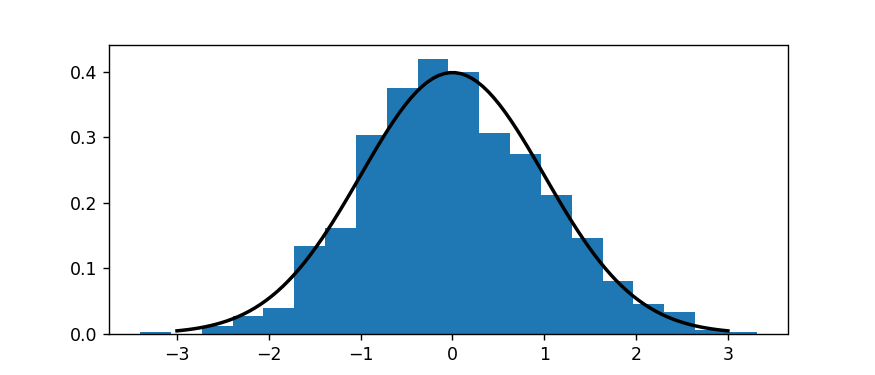

In [20]:
samples = w_prior.rsample(sample_shape=(1000, ))

print(samples.shape)

fig, ax = plt.subplots(figsize=(7, 3))
plt.hist(samples.detach().numpy(), bins=20, density=True)
w_plot = np.linspace(-3, 3, num=100)
w_pdf = torch.exp(w_prior.log_prob(torch.from_numpy(w_plot))).detach().numpy()
plt.plot(w_plot, w_pdf, 'k-', lw=2);

and compute descriptors

In [21]:
display(w_prior.mean)
display(w_prior.stddev)
display(w_prior.entropy())

tensor(0.)

tensor(1.)

tensor(1.4189)

A distribution has two shapes

`event_shape` refers to the dimensionality of the distribution, e.g. normal (number): 0, multivariate normal (vector): 1, Cholesky (matrix): 2

> `event_shape` denotes dependent random variables

`batch_shape` refers to a batch of distributions

> `batch_shape` denotes conditionally independent random variables

We can create a batched distribution by batching the parameters

The shape of a sampled tensor will be the sum of event and batch shapes

In [22]:
# Two conditionally independent normal RVs
w_prior = Normal(torch.tensor([0., 2.]), torch.tensor([1., 1.]))

display(w_prior.batch_shape)
display(w_prior.event_shape)
display(w_prior.rsample().shape)

torch.Size([2])

torch.Size([])

torch.Size([2])

### Random variables

To create random variables that we can track within a model we use [`pyro.sample`](http://pyro.ai/examples/intro_part_i.html#The-pyro.sample-Primitive)

In [23]:
pyro.sample?

def model():
    return pyro.sample('w', w_prior)

This expects a name and an object from [`pyro.distributions`](http://docs.pyro.ai/en/stable/distributions.html)



In [24]:
for i in range(10):
    print(model())

tensor([0.8365, 3.1334])
tensor([0.8077, 1.8372])
tensor([0.0687, 1.9025])
tensor([0.1969, 2.0643])
tensor([0.3770, 0.2038])
tensor([0.6629, 0.3459])
tensor([1.1383, 3.4142])
tensor([0.3496, 0.4173])
tensor([-1.0536,  0.5948])
tensor([0.0483, 2.1740])


### Conditioning

We can create conditions on RV 

Here output we have conditioned the RV "output" by the RV "parameter"

In [25]:
def model(x):
    weight = pyro.sample("weight", Normal(0.0, 10.0))
    bias = pyro.sample("bias", Normal(0.0, 10.0))
    return pyro.sample("output", Normal(x*weight + bias, 1.0))

def conditioned_model(x, y):
    return pyro.condition(model, data={"output": y})(x)

# or equivalently

def model_obs(x, y):  # equivalent to conditioned_scale above
    weight = pyro.sample("weight", Normal(0.0, 10.0))
    bias = pyro.sample("bias", Normal(0.0, 10.0))
    with pyro.plate('plate', size=len(x)):
        return pyro.sample("output", Normal(x*weight + bias, 1.0), obs=y)

# Inference

To estimate the distribution of "parameter" given x and y we will use **Stochastic Variational Inference** (SVI)

> We will review VI in detail in a future class

For the moment let's focus on the practical aspects

First we need a **guide**, a simple function that acts as our approximate posterior, for example

In [26]:
from torch.distributions import constraints

def guide(x, y):
    w_loc = pyro.param("w_loc", torch.tensor(0.))
    w_scale = pyro.param("w_scale", torch.tensor(1.), constraint=constraints.positive)
    b_loc = pyro.param("b_loc", torch.tensor(0.))
    b_scale = pyro.param("b_scale", torch.tensor(1.), constraint=constraints.positive)
    weight = pyro.sample("weight", Normal(w_loc, w_scale))
    bias = pyro.sample("bias", Normal(b_loc, b_scale))

Our approximate posterior is Normal and and we want to estimate the values of $a$ and $b$

### Training

We train this model using [`pyro.infer.SVI`](http://docs.pyro.ai/en/stable/inference_algos.html)

This is the unified Variational Inference interface of Pyro

> SVI expects model, guide, optimizer, loss and the number of samples

We will use adam as optimizer and the Evidence Lower Bound (ELBO) as cost function 

> We will review the ELBO in detail in a future class


<IPython.core.display.Javascript object>


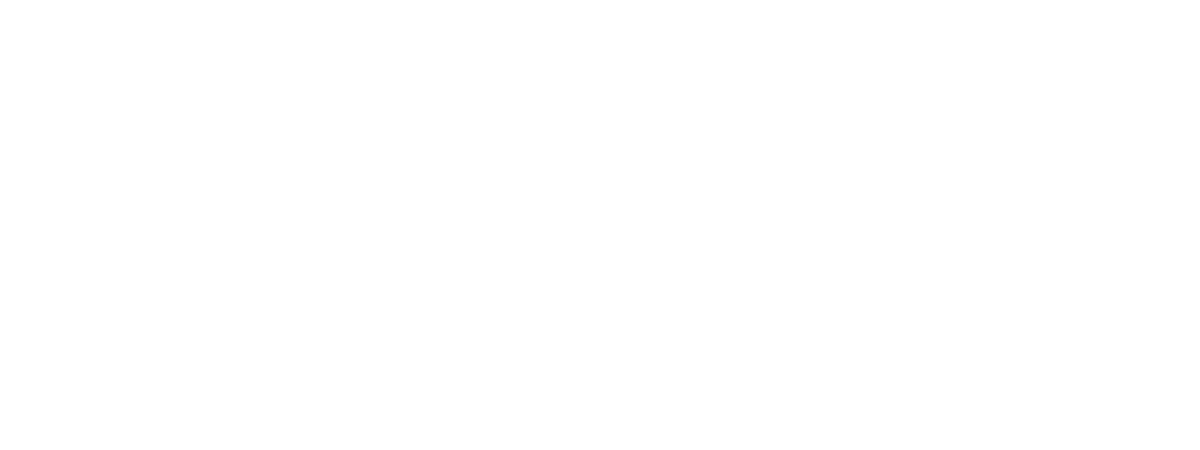

KeyboardInterrupt: 

In [27]:
pyro.enable_validation(True)
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_obs, guide=guide,
                     optim=pyro.optim.Adam({"lr": 0.001}),
                     loss=pyro.infer.Trace_ELBO())

fig, ax = plt.subplots(1, 3, figsize=(8, 3), dpi=120, tight_layout=True)
lines = [ax_.plot([], [])[0] for ax_ in ax]
losses, a,b  = [], [], []
ax[0].set_title('ELBO')
ax[1].set_title('w_loc')
ax[2].set_title('w_scale')
for k in tqdm_notebook(range(7500)):
    losses.append(svi.step(torch.tensor([-2, 2.]), torch.tensor([-2., 0.])))
    a.append(pyro.param("w_loc").item())
    b.append(pyro.param("w_scale").item())
    if np.mod(k, 100) == 0:
        for i, data_plot in enumerate([losses, a, b]):
            lines[i].set_xdata(range(k))
            lines[i].set_ydata(data_plot[:k])
            ax[i].relim()
            ax[i].autoscale_view()
        fig.canvas.draw()

We see that the ELBO and the parameters have converged

We can evaluate our results by observing the marginal and posterior predictive distributions

<IPython.core.display.Javascript object>


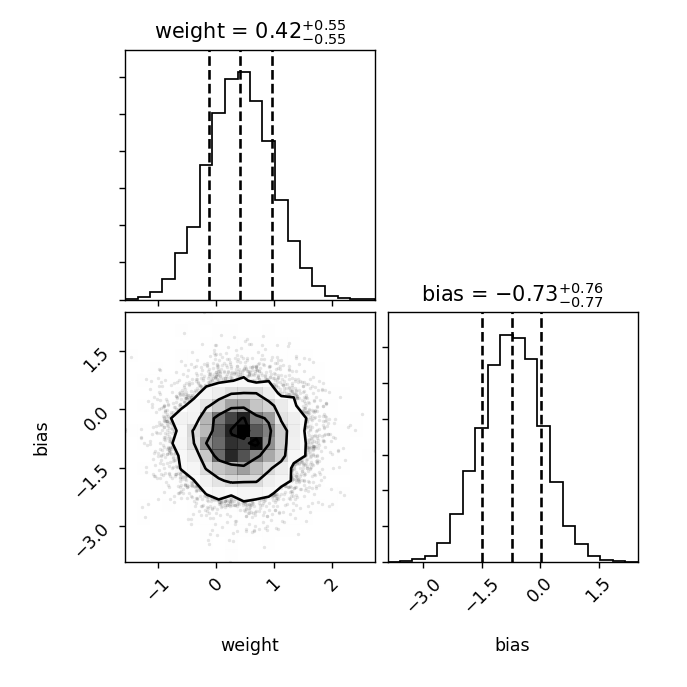

In [28]:
w_plot = Normal(pyro.param('w_loc'), pyro.param('w_scale')).rsample((10000,)).detach().numpy()
b_plot = Normal(pyro.param('b_loc'), pyro.param('b_scale')).rsample((10000,)).detach().numpy()

import corner
figure = corner.corner(np.stack((w_plot, b_plot)).T, 
                       labels=["weight", "bias"], bins=20,
                       quantiles=[0.16, 0.5, 0.84], 
                       show_titles=True, title_kwargs={"fontsize": 12})

<IPython.core.display.Javascript object>


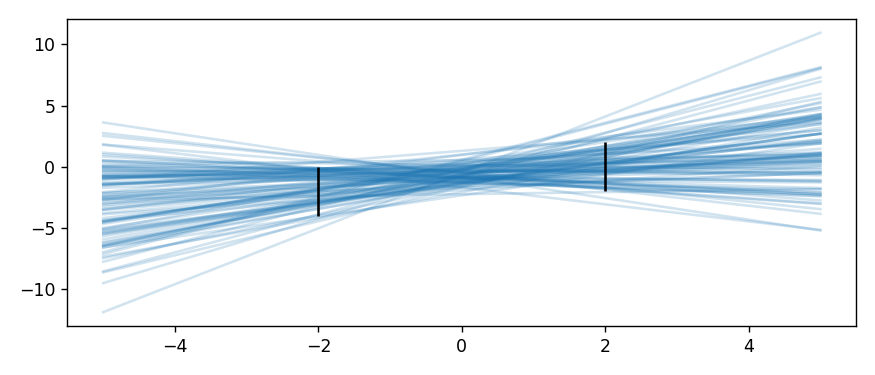

In [29]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)

for i in range(100):    
    line_y = line_x*w_plot[i] + b_plot[i]
    ax.plot(line_x, line_y, c='tab:blue', alpha=0.2)

ax.errorbar(2, 0, xerr=0, yerr=2, fmt='none', c='k', zorder=100);
ax.errorbar(-2, -2., xerr=0, yerr=2, fmt='none', c='k', zorder=100);

## Writing a pyro model for a Bayesian Neural Network


> Let's convert our MLP into a Bayesian MLP using the very helpful function: [`pyro.random_module()`](http://docs.pyro.ai/en/stable/primitives.html?highlight=random_module#pyro.random_module)

In [30]:
pyro.random_module?

This function grabs an object that inherites from `torch.nn.Module` and adds priors to its parameters

In this case the parameters of the model are `hidden.weight`, `hidden.bias`, `output.weight` and `output.bias`

> We will add a Normal prior to these parameters

> We will set $\sigma_\epsilon$ (the noise scale) as a random variable with Uniform distribution


We will use conditioning for the likelihood 

> The likelihood is set to normal with  $f_\theta(x^{(n)})$ as its mean and $\sigma_\epsilon$ as its scale

We condition on the whole dataset (assuming independence) using [`pyro.plate`](http://docs.pyro.ai/en/stable/primitives.html#pyro.plate)

which expects a name and the size of the dataset

`pyro.plate` can be used as iterator or as a context (vectorized plate)

In depth about plates: http://pyro.ai/examples/svi_part_ii.html

In [33]:
class MLP(torch.nn.Module):
    def __init__(self, n_hidden=10):
        super(MLP, self).__init__()
        self.hidden = torch.nn.Linear(1, n_hidden, bias=True)
        self.output = torch.nn.Linear(n_hidden, 1, bias=True)
        self.activation = torch.nn.Tanh()
        
    def forward(self, x):
        return self.output(self.activation(self.hidden(x)))
    
mlp_model = MLP(n_hidden=10)

In [34]:
from pyro.distributions import Normal, Uniform

def model(x, y):
    # We add normal priors to w and b
    w_hidden_prior = Normal(torch.zeros_like(mlp_model.hidden.weight), 
                            torch.ones_like(mlp_model.hidden.weight)).to_event(1)
    b_hidden_prior = Normal(torch.zeros_like(mlp_model.hidden.bias), 
                            torch.ones_like(mlp_model.hidden.bias)).to_event(1)
    w_output_prior = Normal(torch.zeros_like(mlp_model.output.weight), 
                            torch.ones_like(mlp_model.output.weight)).to_event(1)
    b_output_prior = Normal(torch.zeros_like(mlp_model.output.bias), 
                            torch.ones_like(mlp_model.output.bias)).to_event(1)
    priors = {'hidden.weight': w_hidden_prior, 'hidden.bias': b_hidden_prior,
              'output.weight': w_output_prior, 'output.bias': b_output_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", mlp_model, priors)    
    lifted_mlp_model = lifted_module()
    # We create a random variable for the scale
    #scale = pyro.sample("sigma", Uniform(0.01, 10.0))
    # Condition on the dataset assuming iid using a vectorized plate
    with pyro.plate("observed_data", size=len(x)):
        #Get prediction (forward)
        prediction_mean = lifted_mlp_model(x).squeeze(-1)
        pyro.sample("likelihood", Normal(prediction_mean, 0.05), obs=y)
        return prediction_mean

#http://pyro.ai/examples/tensor_shapes.html

In [41]:
print(pyro.poutine.trace(model).get_trace(x_torch, y_torch.squeeze(-1)).format_shapes())

              Trace Shapes:        
               Param Sites:        
              Sample Sites:        
module$$$hidden.weight dist 10 |  1
                      value 10 |  1
  module$$$hidden.bias dist    | 10
                      value    | 10
module$$$output.weight dist  1 | 10
                      value  1 | 10
  module$$$output.bias dist    |  1
                      value    |  1
         observed_data dist    |   
                      value 30 |   
            likelihood dist 30 |   
                      value 30 |   


For the guide we will use the ["auto guide"](https://docs.pyro.ai/en/0.3.0-release/contrib.autoguide.html) functionality

> We will see how to build custom guides for neural nets in a future class

[iteration 0001] loss: 95.6235
[iteration 1001] loss: 18.9937
[iteration 2001] loss: 29.4989
[iteration 3001] loss: 25.7904
[iteration 4001] loss: 21.3322
[iteration 5001] loss: 20.0581
[iteration 6001] loss: 23.5888
[iteration 7001] loss: 75.9788
[iteration 8001] loss: 33.5542
[iteration 9001] loss: 24.1465
[iteration 10001] loss: 30.0428
[iteration 11001] loss: 21.5898
[iteration 12001] loss: 63.7332
[iteration 13001] loss: 32.8761
[iteration 14001] loss: 23.1196
[iteration 15001] loss: 19.0097
[iteration 16001] loss: 18.5747
[iteration 17001] loss: 27.7862
[iteration 18001] loss: 22.5453
[iteration 19001] loss: 32.8900



<IPython.core.display.Javascript object>


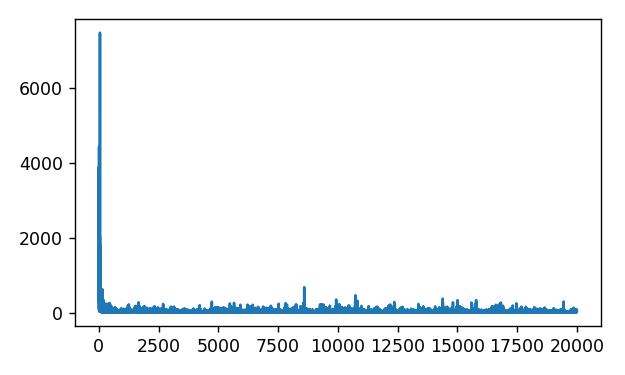

In [42]:
pyro.enable_validation(False)

from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
guide = AutoDiagonalNormal(model)

pyro.clear_param_store()
svi = pyro.infer.SVI(model, guide, pyro.optim.ClippedAdam({"lr": 0.1}), 
                     loss=pyro.infer.Trace_ELBO(), num_samples=100)

#pyro.param("auto_loc", torch.randn(guide.latent_dim))
#pyro.param("auto_scale", 10*torch.ones(guide.latent_dim))
epoch_loss = np.zeros(shape=(20000,))
for k in tqdm_notebook(range(len(epoch_loss))):
    loss = svi.step(x_torch, y_torch.squeeze(-1))
    epoch_loss[k] = loss / len(x_torch)
    if k % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (k + 1, loss / len(x_torch)))
        
fig, ax = plt.subplots(1, figsize=(5, 3), tight_layout=True)
ax.plot(epoch_loss);

### Inspecting the results

We can visualize the posterior

To do this we get the empirical marginal for each parameter

From the samples we can create histograms and compute statistics

<IPython.core.display.Javascript object>


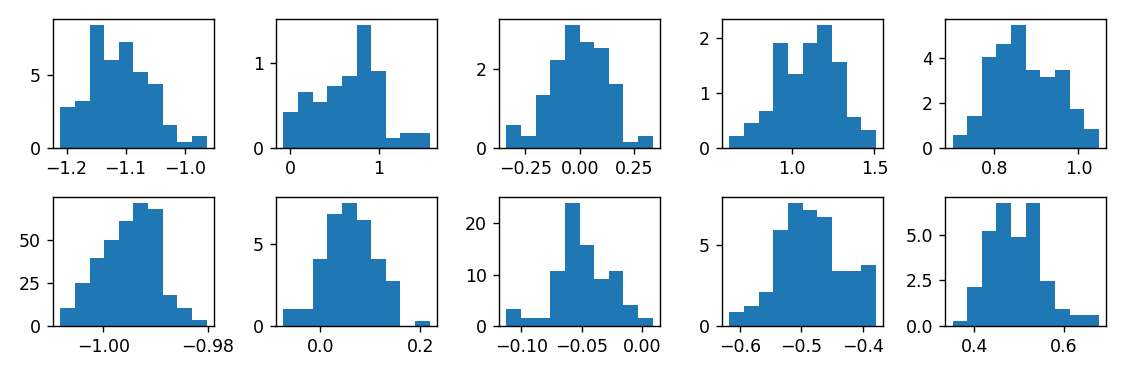

module$$$hidden.weight	0	-1.1888	-1.1146	-1.0195
module$$$hidden.weight	1	0.0344	0.7088	1.2817
module$$$hidden.weight	2	-0.2507	-0.0067	0.1883
module$$$hidden.weight	3	0.7947	1.1008	1.3543
module$$$hidden.weight	4	0.7630	0.8582	1.0026
module$$$output.weight	0	-1.0035	-0.9943	-0.9860
module$$$output.weight	1	-0.0187	0.0592	0.1395
module$$$output.weight	2	-0.0886	-0.0519	-0.0147
module$$$output.weight	3	-0.5689	-0.4916	-0.3962
module$$$output.weight	4	0.4105	0.4896	0.5928


In [43]:
from pyro.infer import EmpiricalMarginal

posterior = svi.run(x_torch, y_torch.squeeze(-1))

fig, ax = plt.subplots(2, 5, figsize=(9, 3), tight_layout=True)
for row, param in enumerate(["module$$$hidden.weight", "module$$$output.weight"]):
    #marginal_trace = EmpiricalMarginal(posterior, param).sample(sample_shape=torch.Size([1000]))
    marginal_trace = EmpiricalMarginal(posterior, param).enumerate_support()
    samples = marginal_trace.reshape(100, -1).detach().numpy()
    for k in range(5): #samples.shape[1]
        print("%s\t%d\t%0.4f\t%0.4f\t%0.4f" %(param, k, *np.quantile(samples[:, k], (0.05, 0.5, 0.95))))
        ax[row, k].hist(samples[:, k], density=True, label=param+' '+str(k))

In [39]:
from pyro.distributions import Delta
from pyro.infer import TracePredictive

def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(model(x_data, y_data)))
    
trace_predictive = TracePredictive(wrapped_model, posterior, num_samples=100)
x_plot = np.linspace(0.0, 1.0, num=200).astype('float32')
posterior_predictive = trace_predictive.run(torch.from_numpy(x_plot[:, None]), None)

<IPython.core.display.Javascript object>


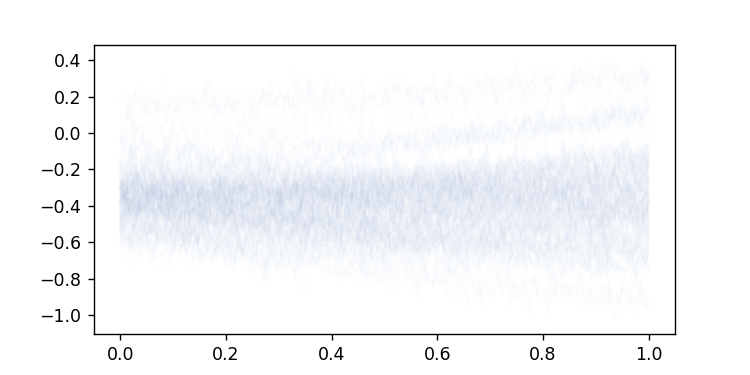

<IPython.core.display.Javascript object>


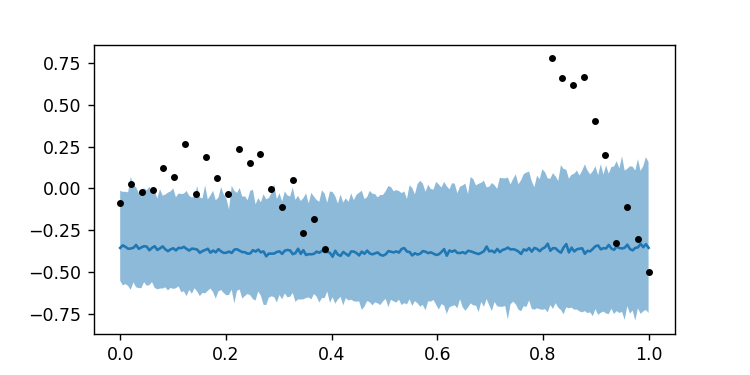

In [44]:
posterior_trace = EmpiricalMarginal(posterior_predictive, "likelihood").enumerate_support().detach().cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 3))
for i in range(posterior_trace.shape[0]):
    ax.plot(x_plot, posterior_trace[i, :], '-', c='royalblue', alpha=0.01)
    
fig, ax = plt.subplots(figsize=(6, 3))
med = np.median(posterior_trace, axis=[0])
qua = np.quantile(posterior_trace, (0.05, 0.95), axis=0)

ax.plot(x_plot, med)
ax.fill_between(x_plot, qua[0], qua[1], alpha=0.5)
ax.plot(x, y, 'k.');

Mean and scale learned for the parameters

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

- http://pyro.ai/examples/
- https://alsibahi.xyz/snippets/2019/06/15/pyro_mnist_bnn_kl.html
- https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd
- https://github.com/paraschopra/bayesian-neural-network-mnist
- https://in.pycon.org/cfp/workshops-2019/proposals/pyro-demystified-bayesian-deep-learning~en4lb/
- https://www.reddit.com/r/MachineLearning/comments/a15r9o/p_bayesian_image_classifier_using_pyro_to_give/eangqch/
- https://medium.com/informatics-lab/probabilistic-programming-1535d7882dbe
   
- https://cscherrer.github.io/post/pyro/        
- https://bookdown.org/robertness/causalml/docs/tutorial-on-deep-probabilitic-modeling-with-pyro.html
- theoretical: https://www.nitarshan.com/bayes-by-backprop/
- independent: https://pdfs.semanticscholar.org/a3fa/183640b1aa6916caaaed6cdea782907d05c4.pdf
- Bayesian layers: https://alsibahi.xyz/snippets/2019/06/15/pyro_mnist_bnn_kl.html

https://cedar.buffalo.edu/~srihari/CSE574/Chap4/4.5.2-VarBayesLogistic.pdf